In [1]:
!pip install category_encoders
import sklearn.preprocessing as pp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt
import math
import pickle
from os.path import exists
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
import ast
import re
from datetime import datetime
from sklearn.feature_selection import r_regression, f_classif , chi2 , mutual_info_classif , SelectKBest
from tkinter import Tk, filedialog
from sklearn.impute import SimpleImputer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from scipy.stats import kstest, norm
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import category_encoders as b
import sklearn.preprocessing as pp
from sklearn.feature_selection import SelectKBest
import sklearn.model_selection as ms
from sklearn.feature_selection import f_classif,r_regression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sklearn.tree import DecisionTreeRegressor
import statsmodels.regression.linear_model as sm
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
#r_regression, f_classif, SelectKBest
from sklearn.feature_selection import r_regression, f_classif , chi2 , mutual_info_classif , SelectKBest
from scipy.stats import kendalltau
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

# Preprocessing

### Address

In [2]:
def parseCountry(x):
    addr = x.split()
    if len(addr) <= 2:
        return x
    if addr[-2] == 'United' and addr[-1] == 'Kingdom':
        return addr[-2] + ' ' + addr[-1]
    else:
        return addr[-1]
def makeColumn(row):
    if row["Hotel_Address"] == row["Reviewer_Nationality"]:
        return 1
    else:
        return 0
def PreprocessAddress(dataset):
  dataset['Reviewer_Nationality'].replace(' Israel ', 'Palestine', inplace=True)
  dataset["Hotel_Address"] = dataset["Hotel_Address"].apply(parseCountry)

### Remove 'Days' from days since review

In [3]:
def parseNDays(x):
    if type(x) is str:
      date = x.split()
      return int(date[0])
    return x
def PreprocessDays(dataset):
  dataset["days_since_review"] = dataset["days_since_review"].apply(parseNDays)

### Review date

In [4]:
def parseDate(x):
    parsedDate = datetime.strptime(x.strip(),'%m/%d/%Y')
    return parsedDate.timestamp() / 3600
def preprocessDates(dataset):
  dataset["Review_month"] = pd.to_datetime(dataset['Review_Date']).dt.month
  dataset['Review_Date'] = dataset['Review_Date'].apply(parseDate)

### Tags

In [5]:
room_type =  ["Privilege ","2 rooms",'Cosy' , 'Luxury',"Apartment",'Classic','Bungalow', 'Villa', 'Penthouse', 'Superior', 'Studio', 'Connecting', 'Suite', 'Deluxe', 'Standard','Executive',"Economy",'Family Room',"Club","City","Guest", "Double Room", " Twin Room"]
def extract_Room(arr):
    for val in arr:
        for word in room_type:
            if word in val:
                return word
    return "None"            # i used other as there is a lot of data that doesn't say the type of room, and there is a lot of types too

In [6]:
def convert_to_array(x):
    return ast.literal_eval(x)

In [7]:
def extract_Nights(arr):
    word = r'Stayed (\d+) night(?:s)?'                      # define the String that we want to Extract
    for val in arr:                                         # becasue it's an array and the index is unknown you check every element in it
        if isinstance(val, str) and re.search(word, val):   # the isinstance check if string, and re.search find patterns between two strings
            stay = int(re.search(word, val).group(1))       # Extect the number from the word, and the augment 1 is to return the first match
            return stay
    return None

In [8]:
room_size = ['Double','Twin','Single',"Triple","Quadruple","Quintuple","King","Queen",'queen']
def extract_Room(arr):
    for val in arr:
        for word in room_size:
            if word in val:
                return word
    return "None"        # same as room type

In [9]:
room_size = ['Family with','Couple','Solo traveler','Group','Travelers with friends']
def extract_customer(arr):
    for val in arr:
        for word in room_size:
            if word in val:
                return val
    return None

In [10]:
device_type = ['Submitted']
def extract_submit(arr):
    for val in arr:
        for word in device_type:
            if word in val:
                return 1
    return 0  # I found only submitted by phone in this dataset, so binary is solution

In [11]:
def PreprocessTags(dataset):
  dataset['Tags'] = dataset['Tags'].apply(convert_to_array)
  Leisure = dataset["Tags"].apply(lambda x: " Leisure trip " in x)
  Business = dataset["Tags"].apply(lambda x: " Business trip " in x)
  dataset.loc[Leisure, 'trip_type'] = 0
  dataset.loc[Business, 'trip_type'] = 1
  df_exploded = dataset.explode('Tags')
  dataset['duration'] = dataset['Tags'].apply(extract_Nights)
  dataset["room_type"] = dataset['Tags'].apply(extract_Room)
  dataset["bed_type"] = dataset['Tags'].apply(extract_Room)
  dataset["customer_type"] = dataset['Tags'].apply(extract_customer)
  dataset["submit"] = dataset['Tags'].apply(extract_submit)
  dataset.drop("Tags",axis =1 ,inplace = True)

### Replace null values

In [12]:

def getPlaceHolders(data):
  placeholders = {}
  dataInfo = data.dtypes
  for col in data.columns:
    if dataInfo[col] == 'object':
      placeholders[col] = data[col].mode()
    else:
      # Check for normality using the Kolmogorov-Smirnov test
      stat, p_value = kstest(data[col].dropna(), 'norm')
      is_normal = p_value >= 0.05
      # Fill missing data with mean or median depending on normality
      if is_normal:
        placeholders[col] = data[col].mean()
      else:
        placeholders[col] = data[col].median()
  return placeholders
def replace_null_values(dataset,placeholders):
    for col in dataset.columns:
      if not (col in placeholders):
          continue
      dataset[col] = dataset[col].fillna(value= placeholders[col])

### Reviews

In [13]:
bad_red = ["Breakfast","Location","Everything","Small room,Expensive","Staff","Room size","Very small room","breakfast","small room","Small room","Parking","Room too small",
"See above","As above","Expensive breakfast","Pillows","No parking","Size of the room","Room very small","Small bathroom","Breakfast not included,Wifi","location","The price","Very small rooms",
"No gym","Size of room","Room was small","Not applicable","Noise","Price of breakfast","Room was very small","Breakfast too expensive","Location" ,"Bathroom","No pool","Everything" ]

good = ["No Negative","Nothing"]
# df
substring = ["No Negative","Nothing"]
# Apply lambda function to check if substring exists in each element of the 'text' column
def neg(x):
  res = []
  for i in range(100):
    for word in good:
      if x[i] in word:
        ""  
      else:
        res.append(x[i])
  return res
def reviewClassifier(review):
    if len(review) > 16: 
        return 1
    else:
        return 0
def PreprocessReviews(dataset):
   #t = dataset['Negative_Review'].apply(lambda x: neg(x))
   #dataset[t]["Negative_Review"].count()
   #t = pd.DataFrame(dataset["Negative_Review"].value_counts())
   #neg(t.index)
   #dataset.drop("Negative_Review",axis = 1,inplace = True)
   #dataset.drop("Positive_Review",axis=1,inplace = True)
  classifyReviews = np.vectorize(reviewClassifier)
  dataset[["Positive_Review","Negative_Review"]] = classifyReviews(dataset[["Positive_Review","Negative_Review"]])

### Encoding

In [14]:
def EncodeLR(dataset):
    dataset.drop('Hotel_Name',axis=1,inplace=True)
    cat_feature = 'Reviewer_Nationality'
    # Compute the frequency of each category in the categorical feature
    freq = dataset[cat_feature].value_counts(normalize=True)
    # Map each category in the feature to its frequency
    dataset[cat_feature] = dataset[cat_feature].map(freq)
    encoder = OneHotEncoder()
    if exists('LRHotEncoder.sav'):
        encoder = pickle.load(open('LRHotEncoder.sav','rb'))
        encoded_data = encoder.transform(dataset[['Hotel_Address']]).toarray() 
        # Create a new DataFrame with the encoded data
        encoded_dataset = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Hotel_Address']))
        # Concatenate the original DataFrame with the encoded DataFrame
        dataset = pd.concat([dataset, encoded_dataset], axis=1)
        # Fit and transform the data
        encoded_data = encoder.transform(dataset[['customer_type']]).toarray()
        # Create a new DataFrame with the encoded data
        encoded_dataset = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['customer_type']))
        # Concatenate the original DataFrame with the encoded DataFrame
        dataset = pd.concat([dataset, encoded_dataset], axis=1)
    else:
        encoded_data = encoder.fit_transform(dataset[['Hotel_Address']]).toarray() 
        # Create a new DataFrame with the encoded data
        encoded_dataset = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Hotel_Address']))
        # Concatenate the original DataFrame with the encoded DataFrame
        dataset = pd.concat([dataset, encoded_dataset], axis=1)
        # Fit and transform the data
        encoded_data = encoder.fit_transform(dataset[['customer_type']]).toarray()
        # Create a new DataFrame with the encoded data
        encoded_dataset = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['customer_type']))
        # Concatenate the original DataFrame with the encoded DataFrame
        dataset = pd.concat([dataset, encoded_dataset], axis=1)
        pickle.dump(encoder,open('LRHotEnconder.sav','wb'))
    # Drop the original 'Hotel_Address' column
    dataset = dataset.drop('customer_type', axis=1)
    # Drop the original 'Hotel_Address' column
    dataset = dataset.drop('Hotel_Address', axis=1)
    # Create a LabelEncoder object
    encoder = LabelEncoder()
    if exists('LRLabelEncoder.sav'):
        encoder = pickle.load(open('LRLabelEncoder.sav','rb'))
        # Fit and transform the data
        dataset["bed_type"] = encoder.transform(dataset["bed_type"])
        dataset["room_type"] = encoder.transform(dataset["room_type"])
    else:
        # Fit and transform the data
        dataset["bed_type"] = encoder.fit_transform(dataset["bed_type"])
        dataset["room_type"] = encoder.fit_transform(dataset["room_type"])
        pickle.dump(encoder,open('LRLabelEncoder.sav','wb'))
    dataset.head()
    return dataset

In [15]:
def fun(x):
  if x == 0:
    return 3
  elif x == 1:
    return 7
  elif x == 2:
    return 5
  elif x == 3:
    return 6
  elif x == 4:
    return 1
  elif x == 5:
    return 4
  elif x == 6:
    return 2
  else:
    return 0
def EncodeGB(dataset):
  dataset = pd.get_dummies(dataset, columns=['Hotel_Address'])
  dataset = pd.get_dummies(dataset, columns=['customer_type'])
  encoder = ce.BinaryEncoder(cols=['Reviewer_Nationality'])
  if exists('Binary1GB.sav'):
    encoder = pickle.load(open('Binary1GB.sav','rb'))
    dataset = encoder.transform(dataset)
  else:
    dataset = encoder.fit_transform(dataset)
    pickle.dump(encoder,open('Binary1GB.sav','wb'))
  # mapping = {'Unknown':0,'Single': 1, 'Twin': 2, 'Double': 3, 'Triple': 4, 'Quadruple': 5, 'Queen':6,'King':7,}
  le = LabelEncoder()
  if exists('LabelEncoderGB.sav'):
    le = pickle.load(open('LabelEncoderGB.sav','rb'))
    dataset["bed_type"] = le.transform(dataset["bed_type"])
  else:
    dataset["bed_type"] = le.fit_transform(dataset["bed_type"])
    pickle.dump(le,open('LabelEncoderGB.sav','wb'))
  dataset["bed_type"] = dataset["bed_type"].apply(fun)
  encoder = ce.BinaryEncoder(cols=['room_type','Hotel_Name'])
  if exists('Binary2GB.sav'):
    encoder = pickle.load(open('Binary2GB.sav','rb'))
    dataset = encoder.transform(dataset)
  else:
    dataset = encoder.fit_transform(dataset)
    pickle.dump(encoder,open('Binary2GB.sav','wb'))
  return dataset

In [16]:
def Encode(dataset):
  encoder = pp.OrdinalEncoder(dtype = np.int32)
  encodedColumns = list()
  for i in dataset:
      if dataset.dtypes[i] == 'object':
        encodedColumns.append(i)
  dataset[encodedColumns] = encoder.fit_transform(dataset[encodedColumns])
  return dataset

### Normalization

In [17]:
def Normalization(dataset):
  numericalColumns = list()
  for i in dataset:
    if dataset.dtypes[i] != 'object':
       numericalColumns.append(i)
  dataset[numericalColumns] = pp.MinMaxScaler((0,1)).fit_transform(dataset[numericalColumns])

## Preprocessing Function

In [18]:
def Preprocessing(dataset):
  PreprocessAddress(dataset)
  PreprocessDays(dataset)
  preprocessDates(dataset)
  PreprocessTags(dataset)
  PreprocessReviews(dataset)
  nullPlaceholders = {}
  if exists('placeholders.sav'):
    placeholdersFile = open('placeholders.sav','rb')
    nullPlaceholders = pickle.load(placeholdersFile)
  else:
    placeholdersFile = open('placeholders.sav',"x")
    placeholdersFile = open('placeholders.sav',"wb")
    nullPlaceholders = getPlaceHolders(dataset)
    pickle.dump(nullPlaceholders,placeholdersFile)
  replace_null_values(dataset,nullPlaceholders)
  Normalization(dataset)
  return dataset

# Feature Selection

In [19]:
def GetNumericalFeatures(dataset):
    return [i for i in dataset if dataset.dtypes[i] != 'object']

In [20]:
def SelectFeatures(X,Y,numericalFunction,kNumerical,categoricalFunction,kCategorical,numerical_cols,cache_name = 'selectedFeatures.sav'):
  if exists(cache_name):
    selected_Names = pickle.load(open(cache_name,'rb'))
    return X[selected_Names]
  else:
    numericalFeatures = list(numerical_cols)
    categoricalFeatures = [i for i in X.columns.values if not i in numerical_cols]
    print(categoricalFeatures)
    for i in X:
      if X.dtypes[i] == 'object':
        categoricalFeatures.append(i)
      else:
        numericalFeatures.append(i)
    numericalSelector = SelectKBest(numericalFunction,k = kNumerical)
    categoricalSelector = SelectKBest(categoricalFunction,k = kCategorical)
    X_numerical = numericalSelector.fit_transform(X,Y)
    X_categorical = categoricalSelector.fit_transform(X,Y)  
    new_X = np.concatenate((X_numerical,X_categorical),axis = 1)
    selected_Names = list(X.columns.values[numericalSelector.get_support()])
    selected_Names = selected_Names + list(X.columns.values[categoricalSelector.get_support()])
    cache_file = open(cache_name,'x')
    cache_file = open(cache_name,'wb')
    pickle.dump(selected_Names,cache_file)
    return new_X

# **Regression**

This section is for hotel_regression only, hotel classification is below

## Loading Dataset 

In [141]:
rawReviews = pd.read_csv("hotel-regression-dataset.csv")
rawReviews = Preprocessing(rawReviews)
Y = rawReviews.loc()[:,"Reviewer_Score"]
numerical_features = GetNumericalFeatures(rawReviews)
rawReviews = EncodeGB(rawReviews.drop('Reviewer_Score',axis=1))

In [142]:
rawReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290315 entries, 0 to 290314
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Additional_Number_of_Scoring                290315 non-null  float64
 1   Review_Date                                 290315 non-null  float64
 2   Average_Score                               290315 non-null  float64
 3   Hotel_Name_0                                290315 non-null  int64  
 4   Hotel_Name_1                                290315 non-null  int64  
 5   Hotel_Name_2                                290315 non-null  int64  
 6   Hotel_Name_3                                290315 non-null  int64  
 7   Hotel_Name_4                                290315 non-null  int64  
 8   Hotel_Name_5                                290315 non-null  int64  
 9   Hotel_Name_6                                290315 non-null  int64  
 

In [143]:
rawReviews.head()

,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name_0,Hotel_Name_1,Hotel_Name_2,Hotel_Name_3,Hotel_Name_4,Hotel_Name_5,Hotel_Name_6,...,Hotel_Address_Italy,Hotel_Address_Netherlands,Hotel_Address_Spain,Hotel_Address_United Kingdom,customer_type_ Couple,customer_type_ Family with older children,customer_type_ Family with young children,customer_type_ Group,customer_type_ Solo traveler,customer_type_ Travelers with friends
0,0.300261,0.895890,0.565217,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.338307,0.326084,0.717391,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.336815,0.527397,0.630435,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0.085416,0.472603,0.739130,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.089519,0.900000,0.500000,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [144]:
rawReviews.isnull().sum()

Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name_0                                  0
Hotel_Name_1                                  0
Hotel_Name_2                                  0
Hotel_Name_3                                  0
Hotel_Name_4                                  0
Hotel_Name_5                                  0
Hotel_Name_6                                  0
Hotel_Name_7                                  0
Hotel_Name_8                                  0
Hotel_Name_9                                  0
Hotel_Name_10                                 0
Reviewer_Nationality_0                        0
Reviewer_Nationality_1                        0
Reviewer_Nationality_2                        0
Reviewer_Nationality_3                        0
Reviewer_Nationality_4                        0
Reviewer_Nationality_5                        0
Reviewer_Nationality_6                  

### Plots

In [145]:
#rawReviews.loc[((rawReviews["bed_type"] == "Queen") | (rawReviews["bed_type"] == "queen")),"bed_type"] = "Queen"           
#plt.hist(rawReviews["bed_type"],align='mid',bins = 20)

In [146]:
#plt.figure(figsize=(10, 6))
#plt.xticks(fontsize=9)
#plt.hist(rawReviews["customer_type"],bins = 50,align='left')

In [147]:
#rawReviews['submit'].value_counts()
#labels = ['Zeros', 'Ones']

#counts = rawReviews['submit'].value_counts()

# create the pie chart
#fig, ax = plt.subplots(figsize=(8, 8))
#ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# add a title
#ax.set_title('Number of people Used there cell phone to book')

# add a legend
#ax.legend()


In [148]:
#plt.figure(figsize=(25, 6))
#plt.hist(rawReviews["room_type"],bins = 30,)

## Random Forest

### Feature Selection

In [150]:
shape = rawReviews.shape
X = SelectFeatures(rawReviews,Y,r_regression,2,f_classif,2,numerical_features)

### Validation

In [151]:
Xtrain,XtestForest,Ytrain,YtestForest = ms.train_test_split(X,Y,test_size=0.2,random_state=12345667)
randomModel = RandomForestRegressor()
#Scores:  [0.20164883 0.20682618 0.19955316 0.19827348 0.21491949]
#Mean:  0.2042442269225707
#STD :  0.006083089642406279
def displayScores(scores):
    print("Scores: ",scores)
    print("Mean: ", scores.mean())
    print("STD : ",scores.std())
displayScores(ms.cross_val_score(randomModel,Xtrain,Ytrain,cv = 5))

Scores:  [0.34465509 0.3533003  0.35132021 0.35713544 0.35133388]
Mean:  0.3515489837798899
STD :  0.004047220264100497


### Train

In [152]:
sampleSpace = dict(n_estimators=range(50,100,10))
randomModel = ms.RandomizedSearchCV(randomModel,sampleSpace,n_iter = 5,random_state = 12345667)
randomModel.fit(Xtrain,Ytrain)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'n_estimators': range(50, 100, 10)},
                   random_state=12345667)

In [153]:
name = 'random_model.sav'
pickle.dump(randomModel, open(name, 'wb'))

## Decision Tree

### Train

In [154]:
# Create the decision tree regressor and fit the model to the training data
treeModel = DecisionTreeRegressor()
treeModel.fit(Xtrain, Ytrain)

DecisionTreeRegressor()

In [155]:
name = 'DecisionTreeRegressor.sav'
pickle.dump(treeModel, open(name, 'wb'))
loaded_file = pickle.load(open(name, 'rb'))
print("result of pickle treeModel: ", loaded_file.score(XtestForest, YtestForest))

result of pickle treeModel:  0.33432586554208577


## Multiple Linear Regression (backward elimination)

### Preprocessing

In [156]:
df = pd.read_csv("hotel-regression-dataset.csv")
df = Preprocessing(df)
df = EncodeLR(df)

In [157]:
for i, col_name in enumerate(df.columns):
    print("Column index:", i+1, "Column name:", col_name)

Column index: 1 Column name: Additional_Number_of_Scoring
Column index: 2 Column name: Review_Date
Column index: 3 Column name: Average_Score
Column index: 4 Column name: Reviewer_Nationality
Column index: 5 Column name: Negative_Review
Column index: 6 Column name: Review_Total_Negative_Word_Counts
Column index: 7 Column name: Total_Number_of_Reviews
Column index: 8 Column name: Positive_Review
Column index: 9 Column name: Review_Total_Positive_Word_Counts
Column index: 10 Column name: Total_Number_of_Reviews_Reviewer_Has_Given
Column index: 11 Column name: days_since_review
Column index: 12 Column name: lat
Column index: 13 Column name: lng
Column index: 14 Column name: Reviewer_Score
Column index: 15 Column name: Review_month
Column index: 16 Column name: trip_type
Column index: 17 Column name: duration
Column index: 18 Column name: room_type
Column index: 19 Column name: bed_type
Column index: 20 Column name: submit
Column index: 21 Column name: Hotel_Address_Austria
Column index: 2

In [158]:
Y_ = df["Reviewer_Score"]
X_ = df.drop("Reviewer_Score",axis = 1)

### Feature Selection

Backward elimination is a technique used for feature selection in machine learning.

Backward elimination is a backward-stepwise regression technique that starts with a model containing all the features and then iteratively removes the least significant feature one at a time until a stopping criterion is met. The stopping criterion can be based on a statistical significance level, a threshold for the change in model performance, or some other criteria.

* Here are the general steps for performing backward elimination:

1-select a significance level to stay in the model (e.g. sl=0.05).

2-fill the full model with possible predictors.

3-consider the predictor with the highest p-value
  if p-value> sl go to step 4 , otherwise go to Finish.
  
4- Remove the predictor .

5- fit the model without this variable.


* Note : 
 p-value : is a measure of the evidence against the null hypothesis, and it helps to determine whether the results of a hypothesis test are statistically significant or not.

In [159]:
X_=np.append(arr=np.ones((290315,1)).astype(int),values=X_,axis=1)

In [160]:
x_opt=X_[: , [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]
regressor_OLS = sm.OLS(endog=Y, exog=x_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reviewer_Score   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     6490.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        03:25:11   Log-Likelihood:             1.0056e+05
No. Observations:              290315   AIC:                        -2.011e+05
Df Residuals:                  290286   BIC:                        -2.008e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.189e+10   1.87e+10     -0.635      0.526   -4.86e+10    2.48e+10
x1             0.0044      0.004      0.999      0.318      -0.004       0.013
x2           129.9559     11.835     10.981      0.000     106.760     153.151
x3             0.4747      0.003    168.712      0.000       0.469       0.480
x4             0.0567      0.002     35.086      0.000       0.053       0.060
x5            -0.0847      0.001   -112.613      0.000      -0.086      -0.083
x6            -0.8572      0.005   -176.128      0.000      -0.867      -0.848
x7            -0.0086      0.005     -1.728      0.084      -0.018       0.001
x8             0.1252      0.001    135.342      0.000       0.123       0.127
x9             0.5895      0.006     94.471      0.000       0.577       0.602
x10            0.0140      0.009      1.498      0.134      -0.004       0.032
x11          129.9499     11.835     10.981      0.000     106.755     153.145
x12           -0.0152      0.018     -0.828      0.408      -0.051       0.021
x13           -0.0013      0.008     -0.169      0.866      -0.016       0.013
x14           -0.0134      0.001    -11.961      0.000      -0.016      -0.011
x15           -0.0327      0.001    -31.514      0.000      -0.035      -0.031
x16            0.0170      0.006      2.827      0.005       0.005       0.029
x17        -5.807e+08   1.65e+09     -0.352      0.725   -3.81e+09    2.65e+09
x18        -5.534e+08    1.6e+09     -0.345      0.730    -3.7e+09    2.59e+09
x19           -0.0027      0.001     -4.025      0.000      -0.004      -0.001
x20         1.627e+10   2.82e+10      0.576      0.564    -3.9e+10    7.16e+10
x21         1.627e+10   2.82e+10      0.576      0.564    -3.9e+10    7.16e+10
x22         1.627e+10   2.82e+10      0.576      0.564    -3.9e+10    7.16e+10
x23         1.627e+10   2.82e+10      0.576      0.564    -3.9e+10    7.16e+10
x24         1.627e+10   2.82e+10      0.576      0.564    -3.9e+10    7.16e+10
x25         1.627e+10   2.82e+10      0.576      0.564    -3.9e+10    7.16e+10
x26        -4.379e+09   9.62e+09     -0.455      0.649   -2.32e+10    1.45e+10
x27        -3.245e+09    6.4e+09     -0.507      0.612   -1.58e+10    9.29e+09
x28        -3.245e+09    6.4e+09     -0.507      0.612   -1.58e+10    9.29e+09
x29        -2.111e+09   3.24e+09     -0.652      0.514   -8.45e+09    4.23e+09
x30        -9.771e+08   1.09e+09     -0.895      0.371   -3.12e+09    1.16e+09
x31         1.571e+08   3.62e+09      0.043      0.965   -6.93e+09    7.25e+09
==============================================================================
Omnibus:                    40053.915   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76033.328
Skew:                          -0.882   Prob(JB):                         0.00
Ku

In [161]:
x_opt=X_[: , [0,2,3,4,5,6,8,9,11,14,15,16,18,19,20,22,23,26,28,29,30,31]]
regressor_OLS = sm.OLS(endog=Y, exog=x_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reviewer_Score   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     8654.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        03:25:12   Log-Likelihood:             1.0056e+05
No. Observations:              290315   AIC:                        -2.011e+05
Df Residuals:                  290293   BIC:                        -2.008e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.925e+09   3.46e+09     -0.845      0.398   -9.71e+09    3.86e+09
x1           129.2065     11.823     10.928      0.000     106.033     152.379
x2             0.4764      0.003    173.246      0.000       0.471       0.482
x3             0.0559      0.002     36.004      0.000       0.053       0.059
x4            -0.0847      0.001   -112.670      0.000      -0.086      -0.083
x5            -0.8573      0.005   -176.178      0.000      -0.867      -0.848
x6             0.1253      0.001    135.519      0.000       0.123       0.127
x7             0.5898      0.006     94.580      0.000       0.578       0.602
x8           129.2005     11.823     10.928      0.000     106.028     152.373
x9            -0.0134      0.001    -11.953      0.000      -0.016      -0.011
x10           -0.0327      0.001    -31.611      0.000      -0.035      -0.031
x11            0.0188      0.006      3.180      0.001       0.007       0.030
x12         2.925e+09   3.46e+09      0.845      0.398   -3.86e+09    9.71e+09
x13           -0.0028      0.001     -4.179      0.000      -0.004      -0.001
x14            0.0033      0.001      2.632      0.008       0.001       0.006
x15           -0.0051      0.001     -4.000      0.000      -0.008      -0.003
x16            0.0079      0.001      7.645      0.000       0.006       0.010
x17         2.925e+09   3.46e+09      0.845      0.398   -3.86e+09    9.71e+09
x18           -0.0080      0.002     -4.635      0.000      -0.011      -0.005
x19        -2.925e+09   3.46e+09     -0.845      0.398   -9.71e+09    3.86e+09
x20         -5.85e+09   6.92e+09     -0.845      0.398   -1.94e+10    7.72e+09
x21        -8.775e+09   1.04e+10     -0.845      0.398   -2.91e+10    1.16e+10
==============================================================================
Omnibus:                    40168.218   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76334.890
Skew:                          -0.883   Prob(JB):                         0.00
Kurtosis:                       4.786   Cond. No.                     1.07e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [162]:
x_opt=X_[: , [0,2,3,4,5,6,8,9,11,14,15,16,18,19,20,22,23,28,29,31]]
regressor_OLS = sm.OLS(endog=Y, exog=x_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reviewer_Score   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     9565.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        03:25:12   Log-Likelihood:             1.0056e+05
No. Observations:              290315   AIC:                        -2.011e+05
Df Residuals:                  290295   BIC:                        -2.009e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -128.3256     11.799    -10.876      0.000    -151.452    -105.199
x1           128.7425     11.799     10.911      0.000     105.617     151.868
x2             0.4764      0.003    173.248      0.000       0.471       0.482
x3             0.0558      0.002     36.001      0.000       0.053       0.059
x4            -0.0847      0.001   -112.673      0.000      -0.086      -0.083
x5            -0.8573      0.005   -176.179      0.000      -0.867      -0.848
x6             0.1253      0.001    135.524      0.000       0.123       0.127
x7             0.5898      0.006     94.584      0.000       0.578       0.602
x8           128.7366     11.799     10.911      0.000     105.611     151.862
x9            -0.0134      0.001    -11.979      0.000      -0.016      -0.011
x10           -0.0327      0.001    -31.951      0.000      -0.035      -0.031
x11            0.0190      0.006      3.204      0.001       0.007       0.031
x12           -0.0011      0.000     -3.308      0.001      -0.002      -0.000
x13           -0.0028      0.001     -4.174      0.000      -0.004      -0.001
x14            0.0033      0.001      2.630      0.009       0.001       0.006
x15           -0.0051      0.001     -3.992      0.000      -0.008      -0.003
x16            0.0079      0.001      7.633      0.000       0.006       0.010
x17           -0.0071      0.001     -6.892      0.000      -0.009      -0.005
x18            0.0100      0.001      9.502      0.000       0.008       0.012
x19            0.0176      0.005      3.488      0.000       0.008       0.028
==============================================================================
Omnibus:                    40127.096   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76239.686
Skew:                          -0.883   Prob(JB):                         0.00
Kurtosis:                       4.785   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [163]:
x_opt=X_[: , [0,2,3,4,5,6,8,9,11,14,15,16,19,20,22,23,28,29,31]]
regressor_OLS = sm.OLS(endog=Y, exog=x_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reviewer_Score   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 1.010e+04
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        03:25:12   Log-Likelihood:             1.0056e+05
No. Observations:              290315   AIC:                        -2.011e+05
Df Residuals:                  290296   BIC:                        -2.009e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -128.1720     11.800    -10.862      0.000    -151.299    -105.045
x1           128.5875     11.799     10.898      0.000     105.461     151.713
x2             0.4771      0.003    173.936      0.000       0.472       0.482
x3             0.0565      0.002     36.694      0.000       0.053       0.059
x4            -0.0847      0.001   -112.674      0.000      -0.086      -0.083
x5            -0.8572      0.005   -176.156      0.000      -0.867      -0.848
x6             0.1253      0.001    135.546      0.000       0.123       0.127
x7             0.5897      0.006     94.574      0.000       0.577       0.602
x8           128.5817     11.799     10.898      0.000     105.456     151.707
x9            -0.0134      0.001    -11.940      0.000      -0.016      -0.011
x10           -0.0344      0.001    -38.323      0.000      -0.036      -0.033
x11            0.0196      0.006      3.318      0.001       0.008       0.031
x12           -0.0027      0.001     -4.098      0.000      -0.004      -0.001
x13            0.0033      0.001      2.687      0.007       0.001       0.006
x14           -0.0050      0.001     -3.916      0.000      -0.007      -0.002
x15            0.0080      0.001      7.716      0.000       0.006       0.010
x16           -0.0074      0.001     -7.230      0.000      -0.009      -0.005
x17            0.0087      0.001      8.912      0.000       0.007       0.011
x18            0.0142      0.005      2.865      0.004       0.004       0.024
==============================================================================
Omnibus:                    40137.462   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76268.734
Skew:                          -0.883   Prob(JB):                         0.00
Kurtosis:                       4.786   Cond. No.                     1.28e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [164]:
x_opt=X_[: , [0,2,3,4,5,6,8,9,11,14,15,19,22,23,28,29]]
regressor_OLS = sm.OLS(endog=Y, exog=x_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Reviewer_Score   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        03:25:12   Log-Likelihood:             1.0054e+05
No. Observations:              290315   AIC:                        -2.011e+05
Df Residuals:                  290299   BIC:                        -2.009e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -126.6482     11.793    -10.739      0.000    -149.762    -103.534
x1           127.0651     11.793     10.775      0.000     103.952     150.178
x2             0.4776      0.003    174.656      0.000       0.472       0.483
x3             0.0542      0.001     37.467      0.000       0.051       0.057
x4            -0.0846      0.001   -112.674      0.000      -0.086      -0.083
x5            -0.8569      0.005   -176.111      0.000      -0.866      -0.847
x6             0.1253      0.001    135.570      0.000       0.124       0.127
x7             0.5908      0.006     94.857      0.000       0.579       0.603
x8           127.0592     11.793     10.775      0.000     103.946     150.172
x9            -0.0134      0.001    -11.903      0.000      -0.016      -0.011
x10           -0.0346      0.001    -38.594      0.000      -0.036      -0.033
x11           -0.0027      0.001     -4.005      0.000      -0.004      -0.001
x12           -0.0057      0.001     -4.503      0.000      -0.008      -0.003
x13            0.0078      0.001      7.601      0.000       0.006       0.010
x14           -0.0074      0.001     -7.188      0.000      -0.009      -0.005
x15            0.0086      0.001      8.853      0.000       0.007       0.010
==============================================================================
Omnibus:                    40136.845   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76262.273
Skew:                          -0.883   Prob(JB):                         0.00
Kurtosis:                       4.785   Cond. No.                     1.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [165]:
# Define the features and target variables
X_ = X_[: , [0,2,3,4,5,6,8,9,11,14,15,19,22,23,28,29]]
X_train , XtestLinear, y_train, YtestLinear = ms.train_test_split(X_,Y,test_size = 0.2,random_state = 12345667)

### Validation

In [166]:
linearModel = LinearRegression()
def displayScores(scores):
    print("Scores: ",scores)
    print("Mean: ", scores.mean())
    print("STD : ",scores.std())
#displayScores(ms.cross_val_score(linearModel,X_train,y_train,cv = 5))

### Train

In [167]:
# Fit the linear regression model to the training data
linearModel.fit(X_train, y_train)

LinearRegression()

In [168]:
name = 'linear_Model.sav'
pickle.dump(linearModel, open(name, 'wb'))
loaded_file = pickle.load(open(name, 'rb'))
print("result of pickle linear_Model: ", loaded_file.score(XtestLinear, YtestLinear))

result of pickle linear_Model:  0.38595523893330386


## Polynomial Regression

### Validation

In [169]:
x_train, XtestPolynomial, y_train, YtestPolynomial = train_test_split(X, Y, test_size=0.2, random_state=42)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(x_train)
polyModel = LinearRegression()
def displayScores(scores):
    print("Scores: ",scores)
    print("Mean: ", scores.mean())
    print("STD : ",scores.std())
displayScores(ms.cross_val_score(polyModel,X_poly,y_train,cv = 5))

Scores:  [0.37539778 0.37396701 0.37438906 0.37354596 0.3725234 ]
Mean:  0.37396464187587963
STD :  0.0009472569448052174


### Train

In [170]:
XtestPolynomial = poly.fit_transform(XtestPolynomial)
polyModel.fit(X_poly, y_train)

LinearRegression()

In [171]:
name = 'Polynomial Regression.sav'
pickle.dump(polyModel, open(name, 'wb'))
loaded_file = pickle.load(open(name, 'rb'))
print("result of pickle Polynomial Regression: ", loaded_file.score(XtestPolynomial, YtestPolynomial))

result of pickle Polynomial Regression:  0.3699426444971854


## Gradient Boosting

### Train

In [172]:
X_train, XtestGradient, y_train , YtestGradient = ms.train_test_split(X,Y,test_size = 0.2,random_state = 42) 

In [173]:
gradientModel = GradientBoostingRegressor()
gradientModel.fit(X_train,y_train)  

GradientBoostingRegressor()

In [174]:
name = 'GradientBoostingRegressor.sav'
pickle.dump(gradientModel, open(name, 'wb'))
loaded_file = pickle.load(open(name, 'rb'))
print("result of pickle GradientBoostingRegressor: ", loaded_file.score(XtestGradient, YtestGradient))

result of pickle GradientBoostingRegressor:  0.3746526224950547


# **Classification**

## **Loading Dataset**

In [22]:
df = pd.read_csv("hotel-classification-dataset.csv")
YEncoder = pp.OrdinalEncoder()
Y = YEncoder.fit_transform(df['Reviewer_Score'].to_numpy().reshape(-1,1))
pickle.dump(YEncoder,open('classificationEncoder.sav','wb'))
df = Preprocessing(df.drop('Reviewer_Score',axis = 1))
numerical_features = GetNumericalFeatures(df)
df = EncodeGB(df)

## Feature Selection

Use ChiSquared, Mutual Info, Kendalltau, and ANOVA to select both numerical and categorical features

### Kendall for non-linear numerical features

In [23]:
numericalFeatures =  numerical_features
for i in numericalFeatures:
    kendallscore = kendalltau(df[i],Y)
    print(i + ": ")
    print(kendallscore)

Additional_Number_of_Scoring: 
KendalltauResult(correlation=0.040095724066043475, pvalue=1.4996286106216534e-159)
Review_Date: 
KendalltauResult(correlation=0.0001567144325390061, pvalue=0.9161748595851048)
Average_Score: 
KendalltauResult(correlation=-0.2791900226531388, pvalue=0.0)
Negative_Review: 
KendalltauResult(correlation=0.3461447405894426, pvalue=0.0)
Review_Total_Negative_Word_Counts: 
KendalltauResult(correlation=0.3344590261157566, pvalue=0.0)
Total_Number_of_Reviews: 
KendalltauResult(correlation=0.058523166418717326, pvalue=0.0)
Positive_Review: 
KendalltauResult(correlation=-0.25380453519047586, pvalue=0.0)
Review_Total_Positive_Word_Counts: 
KendalltauResult(correlation=-0.24226612449779988, pvalue=0.0)
Total_Number_of_Reviews_Reviewer_Has_Given: 
KendalltauResult(correlation=0.008022634698618917, pvalue=3.2220944451169506e-07)


C:\Personal\Programs\Anaconda\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


days_since_review: 
KendalltauResult(correlation=-0.0001567144325390061, pvalue=0.9161748595851048)
lat: 
KendalltauResult(correlation=0.019290170309711568, pvalue=2.2076856353640886e-38)
lng: 
KendalltauResult(correlation=-0.05293217229906505, pvalue=8.815018074347621e-277)
Review_month: 
KendalltauResult(correlation=0.024272013977455716, pvalue=2.4041013112379912e-55)
trip_type: 
KendalltauResult(correlation=0.10156162850411934, pvalue=0.0)
duration: 
KendalltauResult(correlation=0.008989830114743864, pvalue=5.4719329135221515e-08)
submit: 
KendalltauResult(correlation=-0.02022897487065432, pvalue=1.2173956146965164e-28)


### Anova for linear numerical features

In [24]:
#for i in numericalFeatures:
#    anovaScore = f_classif(df[i].to_numpy().reshape((-1,1)),Y.to_numpy().reshape((-1,1)))
#    print(i + ": ")
#    print(anovaScore)

### ChiSquare for categorical features

In [25]:
categoricalFeatures = ["room_type","bed_type","customer_type","duration","submit","Hotel_Address","Hotel_Name","Reviewer_Nationality","Negative_Review","Positive_Review"]
#for i in categoricalFeatures:
    #chi = chi2(df[i],df["Reviewer_Score"])
    #print(i + ": ")
    #print(chi)

### Mutual Information for categorical features

In [26]:
#for i in categoricalFeatures:
 #   mutualScore = mutual_info_classif(df[i].to_numpy().reshape((-1,1)),df["Reviewer_Score"].to_numpy().reshape((-1,1)))
  #  print(i + ": ")
   # print(mutualScore)

### Select common features

In [27]:
X = SelectFeatures(df,Y,r_regression,3,f_classif,2,numerical_features,'classifSelectedFeatures.sav')

## Train test split

In [28]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size= 0.2,random_state = 42)

In [29]:
Y

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

## Training

In [30]:

classification_model = {
    'DT': {
        'model': DecisionTreeClassifier(),
        'params': {
           'min_samples_split' : [5,10,15,20], #min samples to split a node
           'criterion' : ['gini','entropy'], #Function to measure the quality of a split
           'splitter' : ['best','random'],
           'min_samples_leaf' : [1,2,3,4,5],
           'max_features' : [1,50]
        }
    },
    'GBC': {
        'model' : GradientBoostingClassifier(),
        'params' : {
            "loss":["log_loss", "deviance", "exponential"],
            "learning_rate":[0.1,0.01,0.001],
            "n_estimators":[10,100,200],}
         },
    'logistic':{
        'model' : LogisticRegression(),
        'params': {
            'penalty': ['l1', 'l2'],#determines the type of regularization 
            'C': [0.1, 1, 10] #the inverse of the regularization strength
        }
    }
}

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290315 entries, 0 to 290314
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Additional_Number_of_Scoring                290315 non-null  float64
 1   Review_Date                                 290315 non-null  float64
 2   Average_Score                               290315 non-null  float64
 3   Hotel_Name_0                                290315 non-null  int64  
 4   Hotel_Name_1                                290315 non-null  int64  
 5   Hotel_Name_2                                290315 non-null  int64  
 6   Hotel_Name_3                                290315 non-null  int64  
 7   Hotel_Name_4                                290315 non-null  int64  
 8   Hotel_Name_5                                290315 non-null  int64  
 9   Hotel_Name_6                                290315 non-null  int64  
 

In [32]:
Accuracy = [] #an empty array to store the (modelname,Accuracy of model,best parameters)
trainedModels = list()
for name,mp in classification_model.items() : #for loop used to iterate over all the models we have in (parameters_model)
  start_time = time.time()
  classification = GridSearchCV(mp['model'],mp['params'],cv = 2,return_train_score= False) #using GridSearch to get the best parameters for each model
  #CV: number of cross-validations(b2sm al training set l subsets w a3od a3ml train 3leha)(n Combination)
  print(name)
  classification.fit(X_train,Y_train) #train the model
  pickle.dump(classification, open(name + '.sav', 'wb'))
  trainedModels.append({'name':name,'model': classification})
  Accuracy.append({
      'model':name, #model name
      'best_params': classification.best_params_, #best parameters of the model
      'best_Accuracy':classification.best_score_, #best score of the model
      'train_time' : time.time() - start_time, #total train time of the model
      **classification.cv_results_
  })
newdf = pd.DataFrame(Accuracy,columns = ['model','best_Accuracy','best_params','train_time']) #put the array in a new dataframe
newdf

DT


C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\tree\_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_

GBC


C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

logistic


C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

,model,best_Accuracy,best_params,train_time
0,DT,0.673816,"{'criterion': 'gini', 'max_features': 1, 'min_...",11.255920
1,GBC,0.681363,"{'learning_rate': 0.1, 'loss': 'deviance', 'n_...",273.326578
2,logistic,0.680072,"{'C': 0.1, 'penalty': 'l2'}",14.251302


In [38]:
newdf['best_params'][1]

{'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 100}

<AxesSubplot:xlabel='model', ylabel='best_Accuracy'>

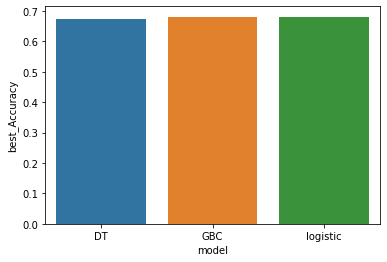

In [34]:
sns.barplot(x = newdf['model'],y = newdf['best_Accuracy'],data = newdf)

# **Evaluate Models**

### Regression

In [23]:
def Evaluate(model,modelName,testSet,actualSet):
    predicted = model.predict(testSet)
    mse = mean_squared_error(actualSet,predicted)
    r2 = r2_score(actualSet,predicted)
    print(modelName,": ")
    print("MSE = " , mse)
    print("R2 Score: " , r2)

In [22]:
Evaluate(randomModel,"Random Forest",XtestForest,YtestForest)
Evaluate(treeModel,"Decision Tree",XtestForest,YtestForest)
Evaluate(linearModel,"Linear Regression",XtestLinear,YtestLinear)
Evaluate(polyModel,"Polynomial Regression",XtestPolynomial,YtestPolynomial)
Evaluate(gradientModel,"Gradient Boost",XtestGradient,YtestGradient)

NameError: name 'Evaluate' is not defined

### Classification

In [21]:
def Evaluate_accuracy(model,modelName,testSet,actualSet):
    start_time = time.time()
    predicted = model.predict(testSet)
    acc = accuracy_score(actualSet,predicted)
    test_time = time.time() - start_time
    print(modelName,": ")
    print("Accuracy = " , acc)
    return test_time

In [ ]:
#Evaluate your model here
test_times = list()
for i in trainedModels:
  test_time = Evaluate_accuracy(i['model'],i['name'],X_test,Y_test)
  test_times.append(test_time)
newdf.insert(1,'test_time',test_times)

In [ ]:
sns.barplot(newdf['model'], newdf['train_time'], data = newdf)

In [ ]:
sns.barplot(newdf['model'], newdf['test_time'], data = newdf)

# **Test Script**

In [24]:
regressionModels = ['DecisionTreeRegressor.sav','random_model.sav','GradientBoostingRegressor.sav']
classificationsModels = ['DT.sav','GBC.sav','logistic.sav']
root = Tk()
root.title = ("Regression Test Set")
file_path = filedialog.askopenfilename(filetypes=[('CSV Files', '*.csv')],parent = root)
df = pd.read_csv(file_path)
#Regression
df = Preprocessing(df)
Y = df['Reviewer_Score']
df_linear = pd.DataFrame.copy(df)
df_linear = EncodeLR(df_linear)
X_linear = df_linear.iloc()[: , [0,2,3,4,5,6,8,9,11,14,15,19,22,23,28,29]]
linear_model = pickle.load(open('linear_Model.sav','rb'))
Evaluate(linear_model,"LinearRegression: ",X_linear,Y)
numerical_features = GetNumericalFeatures(df)
X = EncodeGB(df.drop('Reviewer_Score',axis=1))
X = SelectFeatures(X,Y,r_regression,3,f_classif,2,numerical_features,'selectedFeatures.sav')
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = pickle.load(open('Polynomial Regression.sav','rb'))
Evaluate(model,'Polynomial Regression: ',X_poly,Y)
for i in regressionModels:
    model = pickle.load(open(i,'rb'))
    Evaluate(model,i,X,Y)
#Classification
file_path = filedialog.askopenfilename(filetypes=[('CSV Files', '*.csv')],parent = root)
df = pd.read_csv(file_path)
df = Preprocessing(df)
Y = df['Reviewer_Score']
numerical_features = GetNumericalFeatures(df)
X = EncodeGB(df.drop('Reviewer_Score',axis = 1))
YEncoder = pickle.load(open('classificationEncoder.sav','rb'))
Y = YEncoder.transform(Y.to_numpy().reshape(-1,1))
X = SelectFeatures(X,Y,r_regression,3,f_classif,2,numerical_features,'classifselectedFeatures.sav')
for i in classificationsModels:
    model = pickle.load(open(i,'rb'))
    Evaluate_accuracy(model,i,X,Y)
root.destroy()
#def filesopener(path,name) :
# pickle_file_path = path
# Load the data from the pickle file
# with open(pickle_file_path, 'rb') as file:
#     name = pickle.load(file)

C:\Personal\Programs\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


LinearRegression:  : 
MSE =  3546.831531264638
R2 Score:  -73736.5361899612
Polynomial Regression:  : 
MSE =  0.028081054195261048
R2 Score:  0.4162035237018906
DecisionTreeRegressor.sav : 
MSE =  0.02975112763104935
R2 Score:  0.38148321084637027
random_model.sav : 
MSE =  0.028283523696202576
R2 Score:  0.41199424507632365
GradientBoostingRegressor.sav : 
MSE =  0.02709071058423318
R2 Score:  0.436792462650628
DT.sav : 
Accuracy =  0.648
GBC.sav : 
Accuracy =  0.663
logistic.sav : 
Accuracy =  0.662
